### Unsupervised Learning with GP-LVM

In [1]:
!git clone https://github.com/GPflow/GPflow.git

Cloning into 'GPflow'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 18244 (delta 129), reused 151 (delta 77), pack-reused 17973
Receiving objects: 100% (18244/18244), 65.03 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (13221/13221), done.


In [2]:
%cd GPflow/

/content/GPflow


In [3]:
pip install .

Processing /content/GPflow
     |████████████████████████████████| 3.2MB 12.5MB/s 
  Created wheel for gpflow: filename=gpflow-2.0.0rc1-cp36-none-any.whl size=191987 sha256=5b31da71716ac8c4b6c56671e5b5ac5384632238932b61fed69667c8359b27bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnkjtfj3/wheels/47/4c/15/2288f1725865c2406ba70240d99bab087ab0143e5c08ddc39c
Successfully built gpflow
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
  Found existing installation: tensorflow-probability 0.7.0
    Uninstalling tensorflow-probability-0.7.0:
      Successfully uninstalled tensorflow-probability-0.7.0


In [7]:
!pip install tensorflow --upgrade

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 450kB 49.0MB/s 
     |████████████████████████████████| 3.8MB 44.8MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
pip install tensorflow-probability --upgrade

Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [4]:
from google.colab import files
files.upload()

Saving mnist_train.zip to mnist_train.zip


In [5]:
!unzip mnist_train.zip

Archive:  mnist_train.zip
  inflating: mnist_train.csv         


In [0]:
import numpy as np
import tensorflow as tf

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
%cd GPflow/

/content/GPflow


In [0]:
import csv
data_path = './mnist_train.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    data = np.array(list(reader)).astype(float)

In [4]:
data.shape

(60000, 785)

In [0]:
training_per_class = 700
training_set_1 = data[data[:,0] == 1.]
training_set_5 = data[data[:,0] == 5.]
training_set_9 = data[data[:,0] == 9.]

index_1 = np.random.choice(training_set_1.shape[0],training_per_class,replace=False)
index_5 = np.random.choice(training_set_5.shape[0],training_per_class,replace=False)
index_9 = np.random.choice(training_set_9.shape[0],training_per_class,replace=False)

training_data_1 = training_set_1[index_1][:,1:]/255
training_data_5 = training_set_5[index_5][:,1:]/255
training_data_9 = training_set_9[index_9][:,1:]/255

labels_data_1 = training_set_1[index_1][:,0]
labels_data_5 = training_set_5[index_5][:,0]
labels_data_9 = training_set_9[index_9][:,0]


In [0]:
training_data = np.concatenate((training_data_1, training_data_5, training_data_9), axis = 0)
labels_data = np.concatenate((labels_data_1, labels_data_5, labels_data_9), axis = 0)

In [0]:
Y = tf.convert_to_tensor(training_data, dtype=default_float())

In [0]:
labels = tf.convert_to_tensor(labels_data)

In [9]:
print('Number of points: {} and Number of dimensions: {}'.format(Y.shape[0], Y.shape[1]))

Number of points: 2100 and Number of dimensions: 784


In [0]:
latent_dim = 2  # number of latent dimensions
num_inducing = 25  # number of inducing pts
num_data = Y.shape[0]  # number of data points

In [0]:
x_mean_init = tf.convert_to_tensor(ops.pca_reduce(Y, latent_dim), dtype=default_float())
x_var_init = tf.convert_to_tensor(np.ones((num_data, latent_dim)), dtype=default_float())

In [0]:
inducing_variable = tf.convert_to_tensor(np.random.permutation(x_mean_init.numpy())[:num_inducing], dtype=default_float())

In [0]:
lengthscale = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscale=lengthscale)

In [0]:
gplvm = gpflow.models.BayesianGPLVM(Y,
            x_data_mean=x_mean_init,
            x_data_var=x_var_init,
            kernel=kernel,
            inducing_variable=inducing_variable)

In [15]:
gplvm.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158267>

In [0]:
def check_function(step, variables, values):
    print("Here are the current state of the optimizer :" + str(step))

In [17]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(200)

@tf.function(autograph=False)
def optimization_step():
    return - gplvm.log_marginal_likelihood()

_ = opt.minimize(optimization_step, method="bfgs", variables=gplvm.trainable_variables,step_callback = check_function, options=dict(maxiter=maxiter))

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Here are the current state of the optimizer :0
Here are the current state of the optimizer :1
Here are the current state of the optimizer :2
Here are the current state of the optimizer :3
Here are the current state of the optimizer :4
Here are the current state of the optimizer :5
Here are the current state of the optimizer :6
Here are the current state of the optimizer :7
Here are the current state of the optimizer :8
Here are the current state of the optimizer :9
Here are the current state of the optimizer :10
Here are the current state of the optimizer :11
Here are the current state of the optimizer :12
Here are the current state of the optimizer :13
Here are the current state of the optimizer :14
Here are the current state of the optimizer :15
Here are the current state of the optimizer :16
Here are the current state of the optimizer :17
Here are the current state o

In [18]:
print_summary(gplvm)

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,0.7016209759518928
BayesianGPLVM.kernel.lengthscale,Parameter,Softplus,,True,"(2,)",float64,[7.53393632 1.53477003]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.02644678296719342
BayesianGPLVM.x_data_mean,Parameter,,,True,"(2100, 2)",float64,"[[-0.09401364, 2.83535299..."
BayesianGPLVM.x_data_var,Parameter,Softplus,,True,"(2100, 2)",float64,"[[3.62202235e-02, 1.36901533e-04..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(25, 2)",float64,"[[-2.33258752e+00, -2.99772930e+00..."


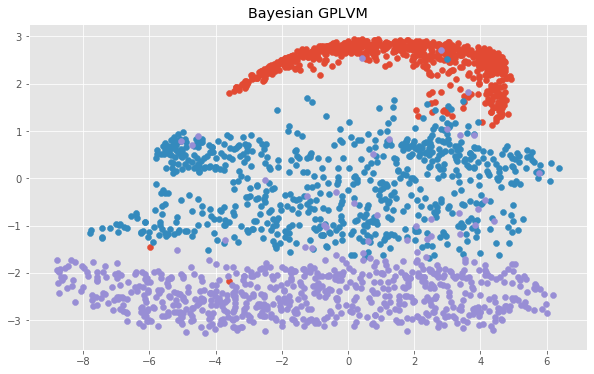

In [19]:
gplvm_x_mean = gplvm.x_data_mean.numpy()

f, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in np.unique(labels):
    ax.scatter(gplvm_x_mean[labels==i, 0], gplvm_x_mean[labels==i, 1], label=i)
    ax.set_title('Bayesian GPLVM')
plt.savefig("Bayesian_GPLVM2.pdf")

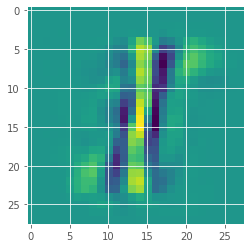

In [55]:
for i in range(-8,6):
  plt.imshow(gplvm.predict_f(tf.constant([[i,3.]], dtype = 'float64'))[0].numpy().reshape((28,28)))
  plt.savefig("./Pictures/FigureLine3" + str(i) + ".png")

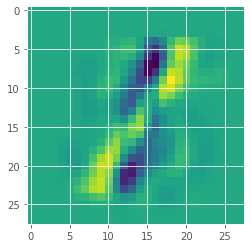

In [64]:
plt.imshow(gplvm.predict_f(tf.constant([[-6.,2.6]], dtype = 'float64'))[0].numpy().reshape((28,28)))

In [65]:
gplvm.predict_f(tf.constant([[-6,2.6]], dtype = 'float64'))[0].numpy().reshape((28,28))

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00

In [0]:
def lol(step=step, variables=variables, values=values):
    print(step)

TypeError: lol() got multiple values for argument 'step'